# Model Selection, Underfitting, and Overfitting

Explore these concepts interactively
by fitting polynomials to data

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Use the following cubic polynomial to generate the labels
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

Take a look at the first 2 samples

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.5738],
         [1.0473]]),
 tensor([[1.0000e+00, 1.5738e+00, 1.2385e+00, 6.4973e-01, 2.5564e-01, 8.0469e-02,
          2.1108e-02, 4.7457e-03, 9.3363e-04, 1.6327e-04, 2.5695e-05, 3.6764e-06,
          4.8218e-07, 5.8375e-08, 6.5623e-09, 6.8854e-10, 6.7728e-11, 6.2702e-12,
          5.4824e-13, 4.5413e-14],
         [1.0000e+00, 1.0473e+00, 5.4837e-01, 1.9143e-01, 5.0118e-02, 1.0497e-02,
          1.8322e-03, 2.7411e-04, 3.5883e-05, 4.1755e-06, 4.3728e-07, 4.1631e-08,
          3.6332e-09, 2.9268e-10, 2.1894e-11, 1.5285e-12, 1.0005e-13, 6.1633e-15,
          3.5859e-16, 1.9765e-17]]),
 tensor([6.1381, 5.3562]))

Implement a function to evaluate the loss on a given dataset

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

Define the training function

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

Third-Order Polynomial Function Fitting (Normal)

weight: [[ 4.969761   1.2375444 -3.332254   5.465167 ]]


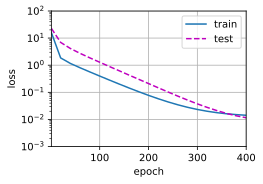

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

Linear Function Fitting (Underfitting)

weight: [[3.8076239 2.6960883]]


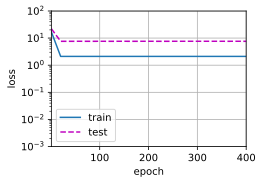

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

Higher-Order Polynomial Function Fitting  (Overfitting)

weight: [[ 4.99965906e+00  1.29651296e+00 -3.41079783e+00  5.11543369e+00
   1.29476888e-02  1.07425332e+00 -1.18181437e-01  3.79335880e-02
   1.57204449e-01 -5.59170125e-03  1.06627844e-01  1.56231105e-01
   1.56704396e-01  5.65945394e-02  1.50019377e-01 -6.80703297e-02
   1.96542568e-03  1.52898461e-01  8.67795348e-02  1.75271243e-01]]


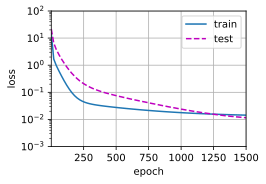

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)